In [ ]:
!pip install -q tensorflow transformers datasets scikit-learn matplotlib seaborn


#LOAD DATASET

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [3]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape


(50000, 2)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.isnull().sum()


,0
review,0
sentiment,0


In [7]:
df['sentiment'].value_counts()


,count
sentiment,
positive,25000
negative,25000


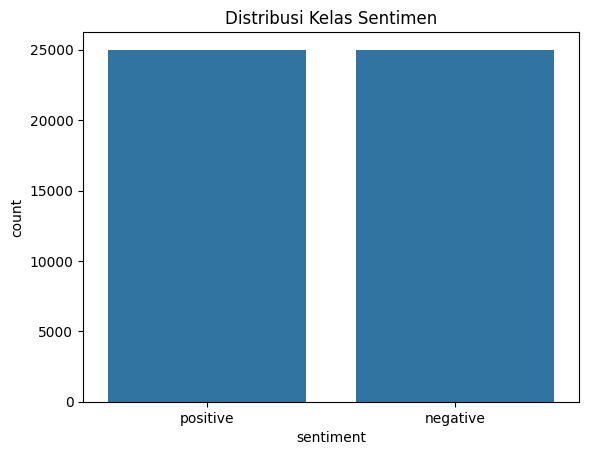

In [8]:
plt.figure()
sns.countplot(x='sentiment', data=df)
plt.title("Distribusi Kelas Sentimen")
plt.show()


In [9]:
df['text_length'] = df['review'].apply(len)
df['text_length'].describe()


,text_length
count,50000.000000
mean,1309.431020
std,989.728014
min,32.000000
25%,699.000000
50%,970.000000
75%,1590.250000
max,13704.000000


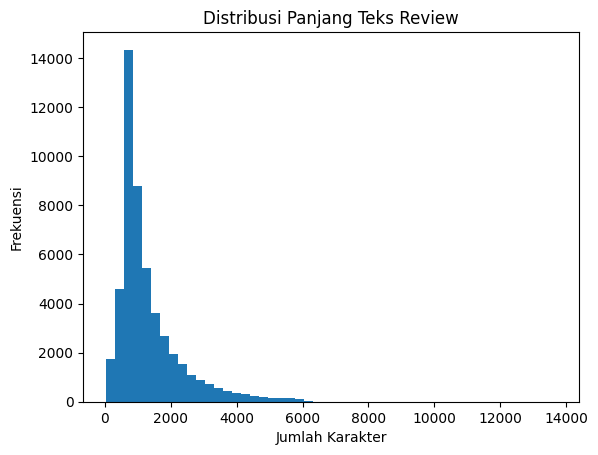

In [10]:
plt.figure()
plt.hist(df['text_length'], bins=50)
plt.title("Distribusi Panjang Teks Review")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.show()


#PREPOCESSING

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)          # hapus HTML tag
    text = re.sub(r'[^a-zA-Z]', ' ', text)     # hapus angka & simbol
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
import re

df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one review mention watch oz episod hook right ...
1,A wonderful little production. <br /><br />The...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visual stun film...


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'],   # ⬅️ PAKAI HASIL PREPROCESSING
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)


In [15]:
print(y_train.dtype)


int64


#TAHAP 3 — TOKENIZATION & PADDING (UNTUK LSTM)

In [ ]:
max_words = 10000   # jumlah kata unik yang dipakai
max_len = 200       # panjang maksimum tiap review

tokenizer = Tokenizer(
    num_words=max_words,
    oov_token="<OOV>"
)

In [ ]:
tokenizer.fit_on_texts(X_train)


In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)


In [ ]:
X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=max_len,
    padding='post',
    truncating='post'
)


In [ ]:
X_train_pad.shape, X_test_pad.shape


((40000, 200), (10000, 200))

In [ ]:
tokenizer.word_index.items()


dict_items([('<OOV>', 1), ('movi', 2), ('film', 3), ('one', 4), ('like', 5), ('time', 6), ('good', 7), ('make', 8), ('charact', 9), ('see', 10), ('watch', 11), ('get', 12), ('even', 13), ('stori', 14), ('would', 15), ('realli', 16), ('well', 17), ('scene', 18), ('look', 19), ('show', 20), ('much', 21), ('end', 22), ('bad', 23), ('peopl', 24), ('great', 25), ('go', 26), ('love', 27), ('also', 28), ('think', 29), ('first', 30), ('act', 31), ('play', 32), ('way', 33), ('thing', 34), ('made', 35), ('could', 36), ('know', 37), ('say', 38), ('seem', 39), ('work', 40), ('plot', 41), ('two', 42), ('actor', 43), ('seen', 44), ('mani', 45), ('come', 46), ('want', 47), ('year', 48), ('take', 49), ('never', 50), ('life', 51), ('best', 52), ('tri', 53), ('littl', 54), ('ever', 55), ('man', 56), ('better', 57), ('give', 58), ('still', 59), ('find', 60), ('perform', 61), ('use', 62), ('feel', 63), ('part', 64), ('someth', 65), ('director', 66), ('actual', 67), ('back', 68), ('lot', 69), ('interest', 

#Membangun Arsitektur Model (LSTM from Scratch)

In [ ]:
model_lstm = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=128,
        input_length=max_len
    ),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 286s 568ms/step - accuracy: 0.5029 - loss: 0.6939 - val_accuracy: 0.5011 - val_loss: 0.6936
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 337s 599ms/step - accuracy: 0.5147 - loss: 0.6888 - val_accuracy: 0.5375 - val_loss: 0.7371
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 272s 545ms/step - accuracy: 0.5573 - loss: 0.6572 - val_accuracy: 0.5702 - val_loss: 0.6735
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 275s 549ms/step - accuracy: 0.6997 - loss: 0.5697 - val_accuracy: 0.7586 - val_loss: 0.5709
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 274s 548ms/step - accuracy: 0.7623 - loss: 0.5174 - val_accuracy: 0.7041 - val_loss: 0.6468


In [ ]:
y_pred_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step


In [ ]:
print(classification_report(y_test, y_pred_lstm))


              precision    recall  f1-score   support

           0       0.65      0.85      0.74      5000
           1       0.79      0.55      0.65      5000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.69     10000
weighted avg       0.72      0.70      0.69     10000



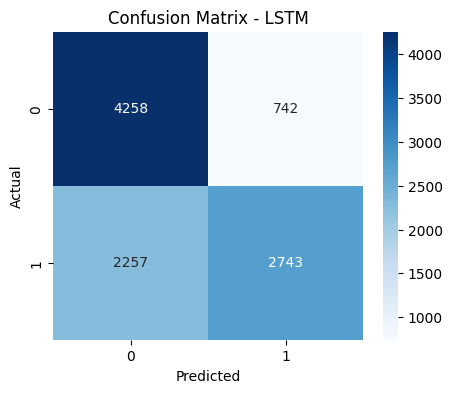

In [ ]:
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM")
plt.show()


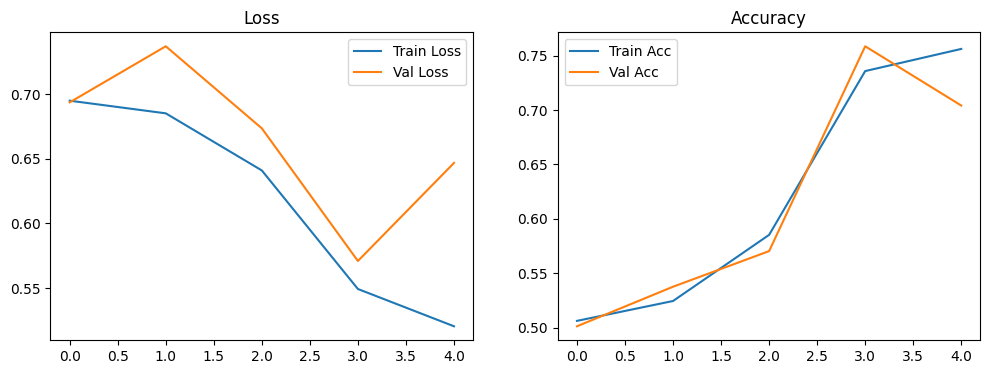

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()


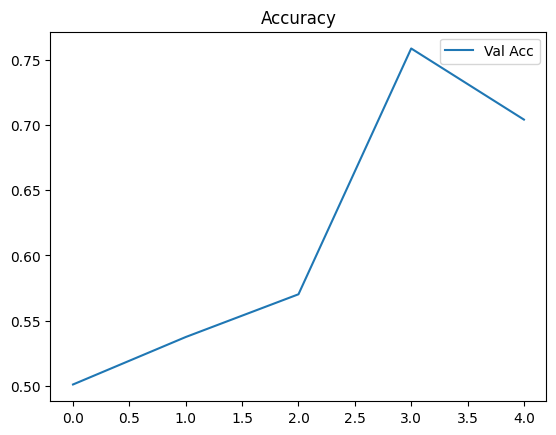

In [ ]:
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()


#MODEL PRETRAINED 1 — BERT (TRANSFER LEARNING)

In [20]:
X_train_bert_small = X_train.sample(n=10000, random_state=42)
y_train_bert_small = y_train.loc[X_train_bert_small.index]

print(len(X_train_bert_small))
print(len(y_train_bert_small))


10000
10000


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import create_optimizer


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
def bert_encode(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

X_train_bert = bert_encode(
    X_train_bert_small.tolist(),
    bert_tokenizer
)

X_test_bert = bert_encode(
    X_test.tolist(),
    bert_tokenizer
)


In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    from_pt=True   # ⬅️ INI KUNCI FIX
)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_model.bert.trainable = False


In [ ]:
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=len(X_train_bert_small) * 3
)

bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
history_bert = bert_model.fit(
    X_train_bert,
    y_train_bert_small,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)


Epoch 1/3
500/500 [==============================] - 6335s 13s/step - loss: 0.7022 - accuracy: 0.5210 - val_loss: 0.6884 - val_accuracy: 0.5825
Epoch 2/3
500/500 [==============================] - 6146s 12s/step - loss: 0.6911 - accuracy: 0.5278 - val_loss: 0.6858 - val_accuracy: 0.6050
Epoch 3/3
500/500 [==============================] - 6153s 12s/step - loss: 0.6881 - accuracy: 0.5471 - val_loss: 0.6838 - val_accuracy: 0.6180


In [ ]:
logits = bert_model.predict(X_test_bert).logits
y_pred_bert = tf.argmax(logits, axis=1).numpy()


313/313 [==============================] - 5925s 19s/step


In [ ]:
print(classification_report(y_test, y_pred_bert))


              precision    recall  f1-score   support

           0       0.59      0.78      0.68      5000
           1       0.68      0.47      0.55      5000

    accuracy                           0.62     10000
   macro avg       0.64      0.62      0.61     10000
weighted avg       0.64      0.62      0.61     10000



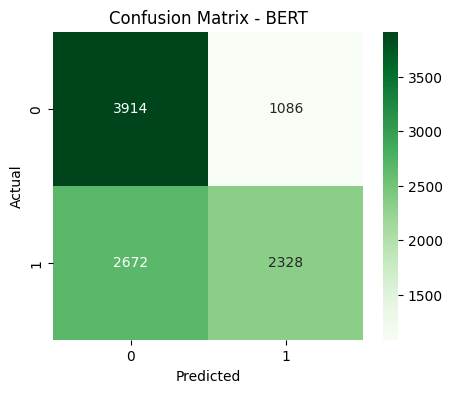

In [ ]:
cm_bert = confusion_matrix(y_test, y_pred_bert)

plt.figure(figsize=(5,4))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BERT")
plt.show()


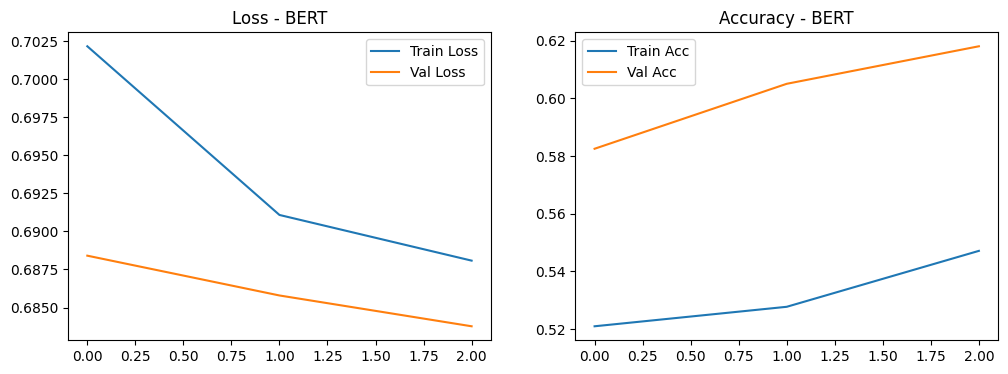

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_bert.history['loss'], label='Train Loss')
plt.plot(history_bert.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss - BERT')

plt.subplot(1,2,2)
plt.plot(history_bert.history['accuracy'], label='Train Acc')
plt.plot(history_bert.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy - BERT')

plt.show()


#DistilBERT

In [16]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import create_optimizer


In [17]:
distil_tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [21]:
def distil_encode(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

X_train_distil = distil_encode(X_train_bert_small, distil_tokenizer)
X_test_distil  = distil_encode(X_test, distil_tokenizer)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [22]:
distil_model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    from_pt=True
)


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

In [23]:
distil_model.distilbert.trainable = False


In [24]:
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=len(X_train_bert_small) * 3
)

distil_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [25]:
history_distil = distil_model.fit(
    X_train_distil,
    y_train_bert_small,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)


Epoch 1/3
500/500 [==============================] - 2717s 5s/step - loss: 0.6600 - accuracy: 0.6225 - val_loss: 0.6183 - val_accuracy: 0.7090
Epoch 2/3
500/500 [==============================] - 2636s 5s/step - loss: 0.6077 - accuracy: 0.6913 - val_loss: 0.5717 - val_accuracy: 0.7320
Epoch 3/3
500/500 [==============================] - 2622s 5s/step - loss: 0.5730 - accuracy: 0.7106 - val_loss: 0.5511 - val_accuracy: 0.7320


In [26]:
logits = distil_model.predict(X_test_distil).logits
y_pred_distil = tf.argmax(logits, axis=1).numpy()

print(classification_report(y_test, y_pred_distil))


313/313 [==============================] - 2546s 8s/step
              precision    recall  f1-score   support

           0       0.76      0.63      0.69      5000
           1       0.69      0.80      0.74      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



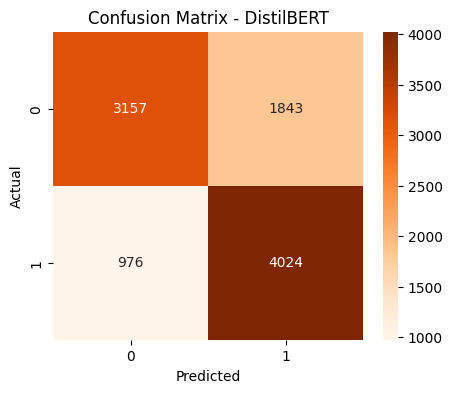

In [27]:
cm_distil = confusion_matrix(y_test, y_pred_distil)

plt.figure(figsize=(5,4))
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT")
plt.show()


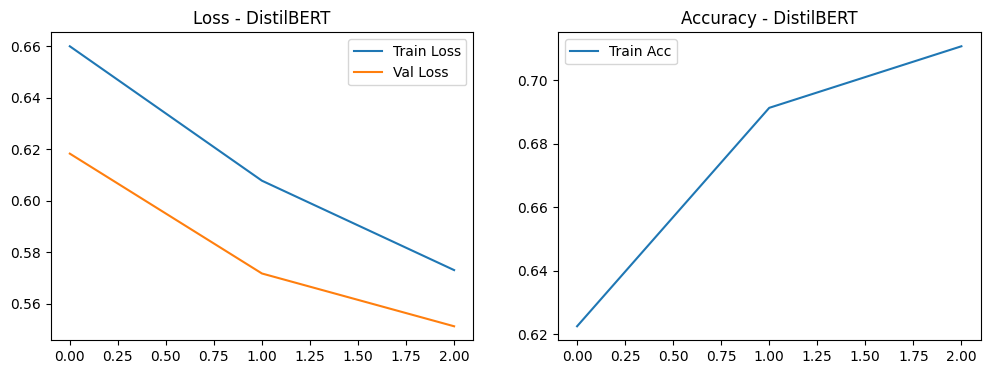

In [28]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_distil.history['loss'], label='Train Loss')
plt.plot(history_distil.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss - DistilBERT')

plt.subplot(1,2,2)
plt.plot(history_distil.history['accuracy'], label='Train Acc')
plt.legend()
plt.title('Accuracy - DistilBERT')

plt.show()
